#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns

In [2]:
from numpy.linalg import eig, svd
from sklearn.decomposition import PCA

In [3]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

In [4]:
from data_loader import makeTensorLoaders

#### Test for CUDA

In [5]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('No GPU, training on CPU')
    device = torch.device('cpu')
else:
    print('GPU found, training on GPU')
    device = torch.device('cuda')

GPU found, training on GPU


#### Simulation parameters

In [6]:
N = 128 ## number of recurrent neurons
nsecs = 500 ## time (originally 1440)
dt = 0.2 ## bin size

In [7]:
nRuns = 5

In [8]:
simtime_len = int(nsecs/dt)

simtime_train = np.arange(0, nsecs, dt)
simtime_test = np.arange(1 * nsecs, 2 * nsecs, dt)

In [9]:
amp = 1.5
freq = 1/50

In [10]:
ft_train_exc = {}
ft_train_inh = {}

In [11]:
scale1 = {}
scale2 = {}
scale3 = {}
scale4 = {}
phi = {}

In [12]:
for cntr in range(nRuns):
    scale1[cntr] = np.random.randint(1,6)
    scale2[cntr] = np.random.randint(1,6)
    scale3[cntr] = np.random.randint(1,6)
    scale4[cntr] = np.random.randint(1,6)
    
    phi[cntr] = -1*np.random.randint(4,7)*np.pi/6
    
    ft_train_exc[cntr] = (amp/1.0) * np.sin(scale1[cntr] *np.pi*freq*simtime_train) 
    + (amp/3.0)*np.sin(scale2[cntr] *np.pi* freq*simtime_train)
    
    ft_train_inh[cntr] = (amp/2.0) * np.sin(scale3[cntr] *np.pi*freq*simtime_train + phi[cntr]) 
    + (amp/0.8)*np.sin(scale4[cntr] *np.pi* freq*simtime_train + phi[cntr])

In [13]:
kk = 4
print(scale1[kk])
print(scale2[kk])

2
2


Text(0.5, 1.0, 'Waveforms')

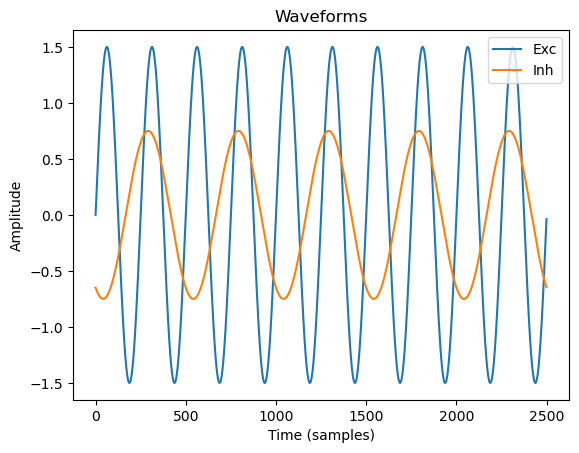

In [14]:
plt.plot(ft_train_exc[kk], label='Exc')
plt.plot(ft_train_inh[kk], label= 'Inh')
plt.legend()
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Waveforms')

#### Train and test datasets

In [15]:
def divide_into_chunks(array, k, n):
    N = len(array)
    start_indices = np.random.randint(0, N - n, size=k)  # Generate k random starting indices
    chunks0 = [array[start_idx:start_idx + n] for start_idx in start_indices]
    chunks1 = [array[start_idx + 1:start_idx + 1 + n] for start_idx in start_indices]
    return np.stack(chunks0), np.stack(chunks1)

In [16]:
batch_size = 100
nSamps_train = 1000
nSamps_test = 1000
lenSeq = 500

In [17]:
data_train_exc = {}
data_train_inh = {}

data_test_exc = {}
data_test_inh = {}

target_train_exc = {}
target_test_exc = {}

target_train_inh = {}
target_test_inh = {}

data_train = {}
data_test = {}

target_train = {}
target_test = {}

In [18]:
train_loader = {}
test_loader = {}

In [19]:
for cntr in range(nRuns):
    data_train_exc[cntr], target_train_exc[cntr] = divide_into_chunks(ft_train_exc[cntr], nSamps_train, lenSeq)
    data_test_exc[cntr], target_test_exc[cntr] = divide_into_chunks(ft_train_exc[cntr], nSamps_test, lenSeq)
    
    data_train_inh[cntr], target_train_inh[cntr] = divide_into_chunks(ft_train_inh[cntr], nSamps_train, lenSeq)
    data_test_inh[cntr], target_test_inh[cntr] = divide_into_chunks(ft_train_inh[cntr], nSamps_test, lenSeq)
    
    data_train[cntr] = np.hstack((np.expand_dims(data_train_exc[cntr],1), np.expand_dims(data_train_inh[cntr],1)))
    data_test[cntr] = np.hstack((np.expand_dims(data_test_exc[cntr],1), np.expand_dims(data_test_inh[cntr],1)))
    
    target_train[cntr] = np.hstack((np.expand_dims(target_train_exc[cntr],1),np.expand_dims(target_train_inh[cntr],1)))
    target_test[cntr] = np.hstack((np.expand_dims(target_test_exc[cntr],1),np.expand_dims(target_test_inh[cntr],1)))
    
    train_loader[cntr] = makeTensorLoaders((data_train[cntr], target_train[cntr]), batch_size, shuffle=True)
    test_loader[cntr] = makeTensorLoaders((data_test[cntr], target_test[cntr]), batch_size, shuffle=True)

#### Model and other hyper-params

In [20]:
num_layers = 1
input_size = 2
hidden_size = N
output_size = 1

In [21]:
def initialize_weights(N, index_ranges, signs):
    weights = np.zeros((N, N))
    for ii, (start, end) in enumerate(index_ranges):
        limit = 1 / np.sqrt(N) if signs[ii] == 1 else -1/np.sqrt(N)
        weights[:, start:end] = np.random.uniform(0, limit, size=(N, end-start))
    return weights

In [22]:
def generate_mask(weights, index_ranges, signs):
    mask = np.zeros_like(weights)
    for i, (start, end) in enumerate(index_ranges):
        if signs[i] == 1:
            mask[:, start:end] = np.where(weights[:, start:end] > 0, 1, 0)
        elif signs[i] == -1:
            mask[:, start:end] = np.where(weights[:, start:end] < 0, 1, 0)
    return mask

In [23]:
frac_ex = 0.8
frac_in = 1-frac_ex

In [24]:
start_ex = 0
end_ex = round(N*frac_ex)
start_in = round(N*frac_ex)
end_in = N

In [25]:
signs = [1,-1]
index_ranges = [(0,int(N*frac_ex)),(int(N*frac_ex),N)]

In [26]:
# Define the neural network
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, frac_list, num_classes, device):
        
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(round(hidden_size*frac_list[0]), num_classes)
        self.fc2 = nn.Linear(round(hidden_size*frac_list[1]), num_classes)
        self.n_classes = num_classes
        self.device = device
        self.fracs = frac_list

    def forward(self, x):
        ## Define input mask
        in_mask = torch.zeros(self.hidden_size, self.input_size).to(device)
        in_mask[start_ex:end_ex,0] = 1.
        in_mask[start_in:end_in,1] = 1.        
        
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        nSamp, inDim, nSteps = x.shape
        
        ops = torch.zeros(nSamp,nSteps,self.hidden_size, requires_grad=False).to(self.device)
        pred1 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        pred2 = torch.zeros(nSamp,nSteps,self.n_classes, requires_grad=False).to(self.device)
        
        for ii in range(nSteps):
            ## Apply input mask
            self.rnn.weight_ih_l0.data.mul(in_mask)
        
            ip = torch.unsqueeze(x[:,:,ii],-1).view(nSamp,1,inDim)
            op, ht = self.rnn(ip,h0) ## pass 1 timestep through RNN
#             fr_mask = ht.clone()>0
#             htt = fr_mask*ht.clone() ## mask firing rate
            h0 = ht ## update hidden state
            ops[:,ii,:] = torch.squeeze(op.clone())

            ## Final prediction at every timestep
            pred1[:,ii,:] = self.fc1(ops[:, ii, :round(self.hidden_size*self.fracs[0])].clone())
            pred2[:,ii,:] = self.fc2(ops[:, ii, round(self.hidden_size*self.fracs[0]):].clone())
            
        out1 = pred1.clone() #Take the output from the last time step
        out2 = pred2.clone() #Take the output from the last time step
        
        return torch.vstack((out1,out2)), ht

In [27]:
# Initialize the model
model = {}
weights_init = {}

In [28]:
for cntr in range(nRuns):
    model[cntr] = SimpleRNN(input_size, hidden_size, [frac_ex, frac_in], output_size, device).to(device)
    weights_init[cntr] = initialize_weights(N,index_ranges,signs)
    model[cntr].rnn.weight_hh_l0.data = torch.from_numpy(weights_init[cntr]).float().to(device)

In [29]:
pp = 1.0
conn_mask = {}
sign_mask = {}
full_mask = {}

In [30]:
for cntr in range(nRuns):
    conn_mask[cntr] = np.random.choice([0, 1], size=(N,N), p=[1-pp, pp])
    sign_mask[cntr] = np.sign(weights_init[cntr])
    sign_mask[cntr][sign_mask[cntr] == 0] = 1
    full_mask[cntr] = torch.from_numpy(sign_mask[cntr]*conn_mask[cntr]).float().to(device)

Text(0.5, 1.0, 'Initial Weights: Rectified Backprop')

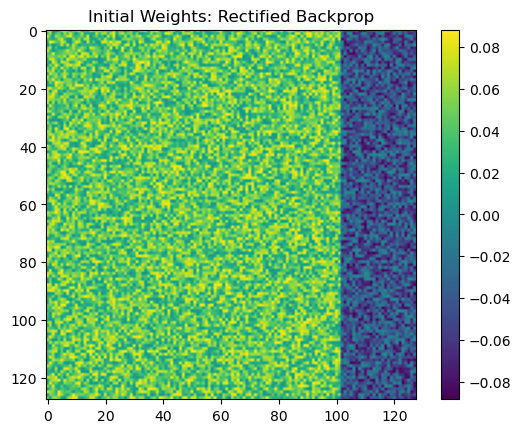

In [31]:
kk = 0

plt.imshow(weights_init[kk])
plt.colorbar()
plt.title('Initial Weights: Rectified Backprop')

Text(0, 0.5, 'Counts')

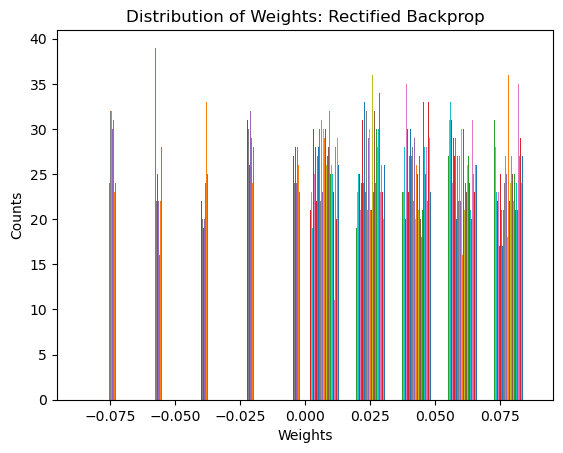

In [32]:
plt.hist(weights_init[kk])
plt.title('Distribution of Weights: Rectified Backprop')
plt.xlabel('Weights')
plt.ylabel('Counts')

#### Model training

In [33]:
num_epochs = 25
learning_rate = 0.001

In [34]:
criterion = nn.MSELoss()

optimizer = {}
for cntr in range(nRuns):
    optimizer[cntr] = optim.Adam(model[cntr].parameters(), lr=learning_rate)

In [35]:
train_losses = np.zeros((nRuns, num_epochs))
test_losses = np.zeros((nRuns, num_epochs))

In [36]:
for run in tqdm(range(nRuns)):
    model[run].train()
    train_loss_min = np.Inf
    for epoch in range(1, num_epochs+1):
        print('Epoch: ',epoch)

        train_loss = 0.0
        test_loss = 0.0
        
        for inputs, targets in train_loader[run]:
            if train_on_gpu:
                inputs, targets = inputs.float().cuda(), torch.unsqueeze(targets.float().cuda(),-1)
                targets_f = torch.vstack((torch.squeeze(targets)[:,0,:],torch.squeeze(targets)[:,1,:]))
                model[run].cuda()
            else:
                inputs, targets = inputs.float(), torch.unsqueeze(targets.float(),-1)
                targets_f = torch.vstack((torch.squeeze(targets)[:,0,:],torch.squeeze(targets)[:,1,:]))

            optimizer[run].zero_grad()
            outputs, firing_rates = model[run](inputs)
            outputs = torch.squeeze(outputs)
            if train_on_gpu:
                outputs = outputs.cuda()
            loss = criterion(outputs, targets_f)
            train_loss += loss.item()

            loss.backward()
            optimizer[run].step()

            ## Rectify weights
            w = model[run].rnn.weight_hh_l0.detach().cpu().numpy()
            w[w < 0] = 0
            model[run].rnn.weight_hh_l0.data = torch.from_numpy(w).float().to(device)
            
            ## Apply mask
            model[run].rnn.weight_hh_l0.data = full_mask[run]*model[run].rnn.weight_hh_l0.data

        if train_loss< train_loss_min:
            print('Epoch: {}, Train Loss Decreased!! ({:.6f}-->{:.6f})'.format(epoch,train_loss_min,train_loss))
            train_loss_min = train_loss
        
        train_losses[run][epoch-1] = train_loss
            
        for inputs_test, targets_test in test_loader[run]:
            if train_on_gpu:
                inputs_test, targets_test = inputs_test.float().cuda(), torch.unsqueeze(targets_test.float().cuda(),-1)
                targets_f_test = torch.vstack((torch.squeeze(targets_test)[:,0,:],torch.squeeze(targets_test)[:,1,:]))
                model[run].cuda()
            else:
                inputs_test, targets_test = inputs_test.float(), torch.unsqueeze(targets_test.float(),-1)
                targets_f_test = torch.vstack((torch.squeeze(targets_test)[:,0,:],torch.squeeze(targets_test)[:,1,:]))
                
            outputs_test, firing_rates_test = model[run](inputs_test)
            outputs_test = torch.squeeze(outputs_test)
            if train_on_gpu:
                outputs_test = outputs_test.cuda()
            loss_test = criterion(outputs_test, targets_f_test)
            test_loss += loss_test.item()
            
        test_losses[run][epoch-1] = test_loss

        print('Epoch: {}, Test Loss({:.6f})'.format(epoch,test_loss))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->7.412723)
Epoch: 1, Test Loss(7.198222)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (7.412723-->7.094232)
Epoch: 2, Test Loss(7.087068)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (7.094232-->7.050091)
Epoch: 3, Test Loss(7.021293)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (7.050091-->7.020104)
Epoch: 4, Test Loss(7.004737)
Epoch:  5
Epoch: 5, Train Loss Decreased!! (7.020104-->6.997782)
Epoch: 5, Test Loss(6.985939)
Epoch:  6
Epoch: 6, Train Loss Decreased!! (6.997782-->6.969352)
Epoch: 6, Test Loss(6.935000)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (6.969352-->6.858227)
Epoch: 7, Test Loss(6.729676)
Epoch:  8
Epoch: 8, Train Loss Decreased!! (6.858227-->6.524368)
Epoch: 8, Test Loss(6.202006)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (6.524368-->5.837468)
Epoch: 9, Test Loss(5.335929)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (5.837468-->4.782358)
Epoch: 10, Test Loss(3.970651)
Epoch:  11
Epoch: 11, Train Loss Decreased!! (4.7823

 20%|██        | 1/5 [12:32<50:10, 752.64s/it]

Epoch: 25, Test Loss(0.044232)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->7.460377)
Epoch: 1, Test Loss(7.288938)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (7.460377-->7.166267)
Epoch: 2, Test Loss(7.041207)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (7.166267-->7.047819)
Epoch: 3, Test Loss(7.015888)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (7.047819-->7.032926)
Epoch: 4, Test Loss(7.062949)
Epoch:  5
Epoch: 5, Train Loss Decreased!! (7.032926-->6.989246)
Epoch: 5, Test Loss(6.887707)
Epoch:  6
Epoch: 6, Train Loss Decreased!! (6.989246-->6.725102)
Epoch: 6, Test Loss(6.451127)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (6.725102-->6.061718)
Epoch: 7, Test Loss(5.492318)
Epoch:  8
Epoch: 8, Train Loss Decreased!! (6.061718-->4.851672)
Epoch: 8, Test Loss(3.926771)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (4.851672-->2.804559)
Epoch: 9, Test Loss(1.283393)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (2.804559-->1.055977)
Epoch: 10, Test Loss(0.836928)
Epoch:  11
Epoch: 11,

 40%|████      | 2/5 [25:22<38:08, 762.99s/it]

Epoch: 25, Test Loss(0.013967)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->7.458472)
Epoch: 1, Test Loss(7.122053)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (7.458472-->7.064592)
Epoch: 2, Test Loss(7.067429)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (7.064592-->7.052853)
Epoch: 3, Test Loss(7.034020)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (7.052853-->7.010153)
Epoch: 4, Test Loss(6.979439)
Epoch:  5
Epoch: 5, Test Loss(6.946985)
Epoch:  6
Epoch: 6, Train Loss Decreased!! (7.010153-->6.846855)
Epoch: 6, Test Loss(6.719640)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (6.846855-->6.602438)
Epoch: 7, Test Loss(6.441413)
Epoch:  8
Epoch: 8, Train Loss Decreased!! (6.602438-->6.268469)
Epoch: 8, Test Loss(6.032958)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (6.268469-->5.784433)
Epoch: 9, Test Loss(5.423015)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (5.784433-->4.970820)
Epoch: 10, Test Loss(4.249272)
Epoch:  11
Epoch: 11, Train Loss Decreased!! (4.970820-->3.361808)
Epoch: 11

 60%|██████    | 3/5 [37:09<24:34, 737.26s/it]

Epoch: 25, Test Loss(0.024503)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->7.124265)
Epoch: 1, Test Loss(7.062486)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (7.124265-->7.078442)
Epoch: 2, Test Loss(7.080408)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (7.078442-->7.036821)
Epoch: 3, Test Loss(7.016669)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (7.036821-->6.985057)
Epoch: 4, Test Loss(6.938626)
Epoch:  5
Epoch: 5, Train Loss Decreased!! (6.985057-->6.878328)
Epoch: 5, Test Loss(6.767702)
Epoch:  6
Epoch: 6, Train Loss Decreased!! (6.878328-->6.644498)
Epoch: 6, Test Loss(6.436741)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (6.644498-->6.121047)
Epoch: 7, Test Loss(5.643668)
Epoch:  8
Epoch: 8, Train Loss Decreased!! (6.121047-->5.095721)
Epoch: 8, Test Loss(4.310382)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (5.095721-->3.429281)
Epoch: 9, Test Loss(2.059077)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (3.429281-->1.337085)
Epoch: 10, Test Loss(1.070371)
Epoch:  11
Epoch: 11,

 80%|████████  | 4/5 [46:55<11:17, 677.64s/it]

Epoch: 25, Test Loss(0.017075)
Epoch:  1
Epoch: 1, Train Loss Decreased!! (inf-->11.528218)
Epoch: 1, Test Loss(9.769199)
Epoch:  2
Epoch: 2, Train Loss Decreased!! (11.528218-->9.681727)
Epoch: 2, Test Loss(9.243116)
Epoch:  3
Epoch: 3, Train Loss Decreased!! (9.681727-->8.710795)
Epoch: 3, Test Loss(8.134689)
Epoch:  4
Epoch: 4, Train Loss Decreased!! (8.710795-->7.730749)
Epoch: 4, Test Loss(7.348208)
Epoch:  5
Epoch: 5, Train Loss Decreased!! (7.730749-->7.181005)
Epoch: 5, Test Loss(7.051881)
Epoch:  6
Epoch: 6, Train Loss Decreased!! (7.181005-->6.872353)
Epoch: 6, Test Loss(6.634317)
Epoch:  7
Epoch: 7, Train Loss Decreased!! (6.872353-->6.417124)
Epoch: 7, Test Loss(6.129479)
Epoch:  8
Epoch: 8, Train Loss Decreased!! (6.417124-->5.765410)
Epoch: 8, Test Loss(5.186437)
Epoch:  9
Epoch: 9, Train Loss Decreased!! (5.765410-->4.483218)
Epoch: 9, Test Loss(3.423772)
Epoch:  10
Epoch: 10, Train Loss Decreased!! (4.483218-->2.220921)
Epoch: 10, Test Loss(1.445188)
Epoch:  11
Epoch: 1

100%|██████████| 5/5 [56:45<00:00, 681.17s/it]

Epoch: 25, Test Loss(0.040223)


In [37]:
outputs_test_np = outputs_test.detach().cpu().numpy()
targets_test_np = targets_test.detach().cpu().numpy()
firing_rates_test_np = firing_rates_test.detach().cpu().numpy()

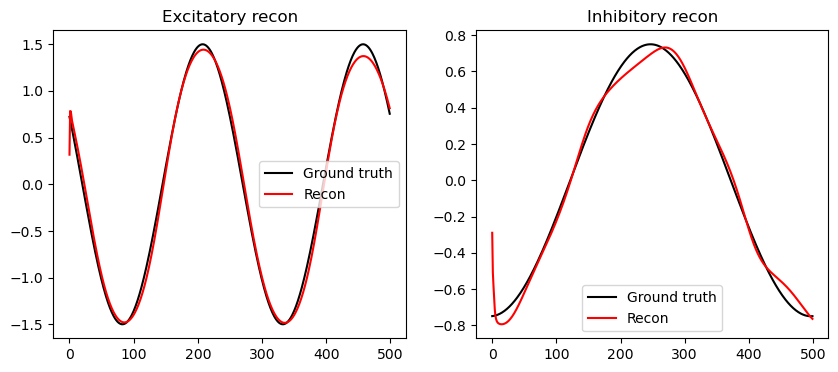

In [38]:
kk = 18

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(targets_test_np[kk,0],label='Ground truth',color='k')
plt.plot(outputs_test_np[kk],label='Recon',color='r')
plt.title('Excitatory recon')
plt.legend()

plt.subplot(122)
plt.plot(targets_test_np[kk,1],label='Ground truth',color='k')
plt.plot(outputs_test_np[batch_size+kk],label='Recon',color='r')
plt.title('Inhibitory recon')
plt.legend()

In [39]:
weights_final = {}
for cntr in range(nRuns):
    weights_final[cntr] = model[cntr].rnn.weight_hh_l0.detach().cpu().numpy()

Text(0, 0.5, 'Counts')

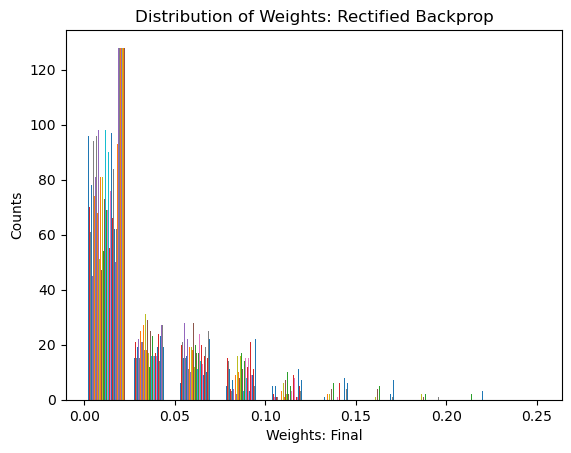

In [40]:
kk = 0
plt.hist(weights_final[kk])
plt.title('Distribution of Weights: Rectified Backprop')
plt.xlabel('Weights: Final')
plt.ylabel('Counts')

In [41]:
mean_train_losses = np.mean(train_losses, axis=0)
variance_train_losses = np.var(train_losses, axis=0)

mean_test_losses = np.mean(test_losses, axis=0)
variance_test_losses = np.var(test_losses, axis=0)

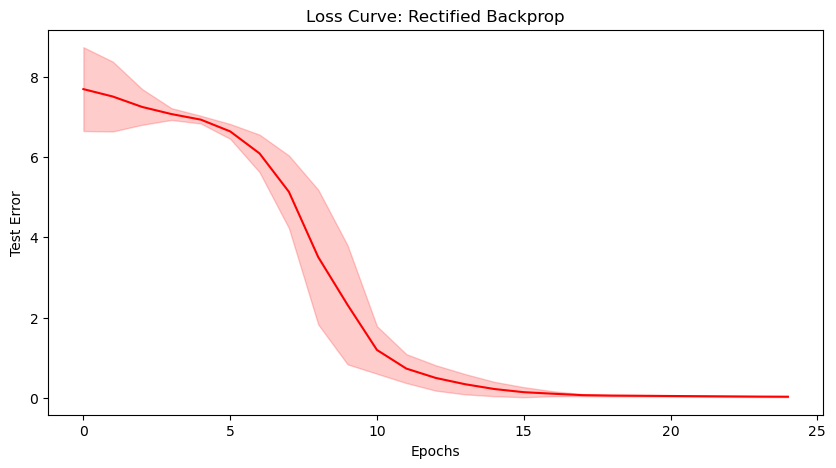

In [42]:
# Define x-axis (epochs)
x = np.arange(num_epochs)

# Plot shaded error bar using Seaborn
plt.figure(figsize=(10, 5))
# sns.lineplot(x=x, y=mean_train_losses, color='r')
# plt.fill_between(x, mean_train_losses - np.sqrt(variance_train_losses), mean_train_losses + np.sqrt(variance_train_losses),
#                  color='r', alpha=0.2)

sns.lineplot(x=x, y=mean_test_losses, color='r')
plt.fill_between(x, mean_test_losses - np.sqrt(variance_test_losses), mean_test_losses + np.sqrt(variance_test_losses),
                 color='r', alpha=0.2)

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Test Error')
plt.title('Loss Curve: Rectified Backprop')

# Show plot
plt.show()

#### Saves

In [43]:
## Save train, test losses + accuracies
np.save('wave_recon_train_losses_rectified_backprop',train_losses)
np.save('wave_recon_test_losses_rectified_backprop',test_losses)

In [44]:
# Save dictionary to a Numpy .npz file
np.savez('wave_recon_weights_init_rectified.npz', weights_init, pickle=True)
np.savez('wave_recon_weights_final_rectified.npz', weights_final, pickle=True)